In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genextreme, kendalltau
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from fancyimpute import IterativeSVD
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# 📂 Carregar dados
caminho_arquivo = "C:/Python/Waves/maputoo.xlsx"
df = pd.read_excel(caminho_arquivo)

# 📋 Corrigir colunas
df.columns = ['YEAR', 'DIA_MES', 'T2M_MAX', 'T2M_MIN']

# 📅 Corrigir Datas
df['DIA_MES'] = pd.to_datetime(df['DIA_MES'])

def corrigir_ano(row):
    try:
        return row['DIA_MES'].replace(year=int(row['YEAR']))
    except ValueError:
        if row['DIA_MES'].month == 2 and row['DIA_MES'].day == 29:
            return row['DIA_MES'].replace(day=28, year=int(row['YEAR']))
        else:
            return pd.NaT

df['DATA_COMPLETA'] = df.apply(corrigir_ano, axis=1)
df = df.dropna(subset=['DATA_COMPLETA'])

# 📈 Criar T2M_MED
df['T2M_MED'] = (df['T2M_MAX'] + df['T2M_MIN']) / 2


In [43]:
# 📋 Verificar erros físicos (Tmin > Tmax)
erros_fisicos = df[df['T2M_MIN'] > df['T2M_MAX']]
print(f"Erros físicos detectados: {len(erros_fisicos)}")

# 📋 Verificar valores extremos físicos (>50°C ou <-10°C para Maputo)
outliers = df[(df['T2M_MAX'] > 50) | (df['T2M_MIN'] < -10)]
print(f"Valores extremos fora da climatologia plausível: {len(outliers)}")

# 📋 Detectar duplicatas
duplicados = df[df.duplicated(subset=['DATA_COMPLETA'])]
print(f"Registros duplicados: {len(duplicados)}")

# 📋 Verificar buracos na série temporal
df = df.sort_values('DATA_COMPLETA')
df['DIFERENCA'] = df['DATA_COMPLETA'].diff().dt.days
buracos = df[df['DIFERENCA'] > 1]
print(f"Buracos (dias ausentes) na série: {len(buracos)}")

# 📋 Remover duplicados
df = df.drop_duplicates(subset=['DATA_COMPLETA'])
print(f"Após remoção de duplicados, total de registros: {len(df)}")


Erros físicos detectados: 0
Valores extremos fora da climatologia plausível: 0
Registros duplicados: 20
Buracos (dias ausentes) na série: 20
Após remoção de duplicados, total de registros: 14621


In [44]:
from fancyimpute import IterativeSVD
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# 📋 Normalizar variáveis
variaveis = ['T2M_MAX', 'T2M_MIN', 'T2M_MED']
dados_norm = StandardScaler().fit_transform(df[variaveis])

# 📋 Análise de PCA
pca = PCA()
pca.fit(dados_norm)

variancia_acumulada = np.cumsum(pca.explained_variance_ratio_)

# 📋 Mostrar número de componentes para 90% da variância
n_componentes_90 = np.argmax(variancia_acumulada >= 0.90) + 1
print(f"Número de componentes para explicar ≥90% da variância: {n_componentes_90}")

# 📋 Imputação via IterativeSVD (com rank=2)
imputer = IterativeSVD(rank=2)
dados_imputados = imputer.fit_transform(df[variaveis])

# 📋 Atualizar valores imputados
df['T2M_MAX'] = dados_imputados[:, 0]
df['T2M_MIN'] = dados_imputados[:, 1]
df['T2M_MED'] = dados_imputados[:, 2]


Número de componentes para explicar ≥90% da variância: 2
[IterativeSVD] Iter 1: observed MAE=0.930681
[IterativeSVD] Iter 2: observed MAE=0.000000
[IterativeSVD] Iter 3: observed MAE=0.000000
[IterativeSVD] Iter 4: observed MAE=0.000000
[IterativeSVD] Iter 5: observed MAE=0.000000
[IterativeSVD] Iter 6: observed MAE=0.000000
[IterativeSVD] Iter 7: observed MAE=0.000000
[IterativeSVD] Iter 8: observed MAE=0.000000
[IterativeSVD] Iter 9: observed MAE=0.000000
[IterativeSVD] Iter 10: observed MAE=0.000000
[IterativeSVD] Iter 11: observed MAE=0.000000
[IterativeSVD] Iter 12: observed MAE=0.000000
[IterativeSVD] Iter 13: observed MAE=0.000000
[IterativeSVD] Iter 14: observed MAE=0.000000
[IterativeSVD] Iter 15: observed MAE=0.000000
[IterativeSVD] Iter 16: observed MAE=0.000000
[IterativeSVD] Iter 17: observed MAE=0.000000
[IterativeSVD] Iter 18: observed MAE=0.000000
[IterativeSVD] Iter 19: observed MAE=0.000000
[IterativeSVD] Iter 20: observed MAE=0.000000
[IterativeSVD] Iter 21: observed

c:\Users\Dell\anaconda3\Lib\site-packages\fancyimpute\solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")
C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[IterativeSVD] Iter 117: observed MAE=0.000000
[IterativeSVD] Iter 118: observed MAE=0.000000
[IterativeSVD] Iter 119: observed MAE=0.000000
[IterativeSVD] Iter 120: observed MAE=0.000000
[IterativeSVD] Iter 121: observed MAE=0.000000
[IterativeSVD] Iter 122: observed MAE=0.000000
[IterativeSVD] Iter 123: observed MAE=0.000000
[IterativeSVD] Iter 124: observed MAE=0.000000
[IterativeSVD] Iter 125: observed MAE=0.000000
[IterativeSVD] Iter 126: observed MAE=0.000000
[IterativeSVD] Iter 127: observed MAE=0.000000
[IterativeSVD] Iter 128: observed MAE=0.000000
[IterativeSVD] Iter 129: observed MAE=0.000000
[IterativeSVD] Iter 130: observed MAE=0.000000
[IterativeSVD] Iter 131: observed MAE=0.000000
[IterativeSVD] Iter 132: observed MAE=0.000000
[IterativeSVD] Iter 133: observed MAE=0.000000
[IterativeSVD] Iter 134: observed MAE=0.000000
[IterativeSVD] Iter 135: observed MAE=0.000000
[IterativeSVD] Iter 136: observed MAE=0.000000
[IterativeSVD] Iter 137: observed MAE=0.000000
[IterativeSVD

In [45]:
# 📋 1. Primeiro calcular o DOY (se ainda não fez)
df['DOY'] = df['DATA_COMPLETA'].dt.dayofyear

# 📋 2. Calcular a climatologia diária
climatologia = df.groupby('DOY').agg(
    Normal_Tmax=('T2M_MAX', 'mean'),
    Desvio_Tmax=('T2M_MAX', 'std'),
    Percentil90_Tmax=('T2M_MAX', lambda x: np.percentile(x, 90)),
    Percentil10_Tmax=('T2M_MAX', lambda x: np.percentile(x, 10)),

    Normal_Tmin=('T2M_MIN', 'mean'),
    Desvio_Tmin=('T2M_MIN', 'std'),
    Percentil90_Tmin=('T2M_MIN', lambda x: np.percentile(x, 90)),
    Percentil10_Tmin=('T2M_MIN', lambda x: np.percentile(x, 10)),

    Normal_Tmed=('T2M_MED', 'mean'),
    Desvio_Tmed=('T2M_MED', 'std'),
    Percentil90_Tmed=('T2M_MED', lambda x: np.percentile(x, 90)),
    Percentil10_Tmed=('T2M_MED', lambda x: np.percentile(x, 10))
).reset_index()

# 📋 3. Integrar a climatologia no dataframe principal
df = df.merge(climatologia, on='DOY', how='left')


In [46]:
# 📋 Anomalias em relação à climatologia
df['Anomalia_Tmax'] = df['T2M_MAX'] - df['Normal_Tmax']
df['Anomalia_Tmin'] = df['T2M_MIN'] - df['Normal_Tmin']
df['Anomalia_Tmed'] = df['T2M_MED'] - df['Normal_Tmed']


In [47]:
# 📋 Definição de extremos
df['Extremo_Calor_Tmax'] = df['T2M_MAX'] > df['Percentil90_Tmax']
df['Extremo_Frío_Tmin'] = df['T2M_MIN'] < df['Percentil10_Tmin']

# 📋 Extremos combinados (se quiser usar depois)
df['Evento_Extremo'] = df['Extremo_Calor_Tmax'] | df['Extremo_Frío_Tmin']

# 📋 Verificação
print("✅ Extremos de calor detectados:", df['Extremo_Calor_Tmax'].sum())
print("✅ Extremos de frio detectados:", df['Extremo_Frío_Tmin'].sum())


✅ Extremos de calor detectados: 1456
✅ Extremos de frio detectados: 1452


In [48]:
from scipy.stats import genextreme

# 📋 Agrupar máximos anuais (para calor extremo)
tmax_anuais = df.groupby('YEAR')['T2M_MAX'].max()

# 📋 Agrupar mínimos anuais (para frio extremo)
tmin_anuais = df.groupby('YEAR')['T2M_MIN'].min()

# 📋 Ajustar GEV para Tmax (calor extremo)
shape_max, loc_max, scale_max = genextreme.fit(tmax_anuais)
print(f"🔴 GEV Tmax: shape={shape_max:.4f}, loc={loc_max:.2f}, scale={scale_max:.2f}")

# 📋 Ajustar GEV para Tmin (frio extremo)
shape_min, loc_min, scale_min = genextreme.fit(-tmin_anuais)  # Inverter o sinal para frio
print(f"🔵 GEV Tmin (invertido): shape={shape_min:.4f}, loc={-loc_min:.2f}, scale={scale_min:.2f}")


🔴 GEV Tmax: shape=0.4929, loc=39.11, scale=1.76
🔵 GEV Tmin (invertido): shape=0.7021, loc=11.20, scale=1.47


In [49]:
# 📋 Definir tempos de retorno
tempos_retorno = np.array([2, 5, 10, 20, 50, 100])

# 📋 Configurar Bootstrap
n_bootstrap = 2000
np.random.seed(42)


In [51]:
return_levels_bootstrap_max = []

for _ in range(n_bootstrap):
    simulados = genextreme.rvs(shape_max, loc_max, scale_max, size=len(tmax_anuais))
    try:
        shape_b, loc_b, scale_b = genextreme.fit(simulados)
        levels = genextreme.ppf(1-1/tempos_retorno, shape_b, loc_b, scale_b)
        return_levels_bootstrap_max.append(levels)
    except:
        continue

return_levels_bootstrap_max = np.array(return_levels_bootstrap_max)

# 📋 Calcular Intervalos de Confiança Tmax
lower_bounds_max = np.percentile(return_levels_bootstrap_max, 2.5, axis=0)
upper_bounds_max = np.percentile(return_levels_bootstrap_max, 97.5, axis=0)

# 📋 Níveis Centrais Tmax
central_levels_max = genextreme.ppf(1-1/tempos_retorno, shape_max, loc_max, scale_max)


In [52]:
return_levels_bootstrap_min = []

for _ in range(n_bootstrap):
    simulados = genextreme.rvs(shape_min, loc_min, scale_min, size=len(tmin_anuais))
    try:
        shape_b, loc_b, scale_b = genextreme.fit(simulados)
        levels_invertidos = genextreme.ppf(1-1/tempos_retorno, shape_b, loc_b, scale_b)
        levels_real = -levels_invertidos  # Corrigir o sinal de volta para temperaturas reais
        return_levels_bootstrap_min.append(levels_real)
    except:
        continue

return_levels_bootstrap_min = np.array(return_levels_bootstrap_min)

# 📋 Calcular Intervalos de Confiança Tmin
lower_bounds_min = np.percentile(return_levels_bootstrap_min, 2.5, axis=0)
upper_bounds_min = np.percentile(return_levels_bootstrap_min, 97.5, axis=0)

# 📋 Níveis Centrais Tmin
central_levels_min = -genextreme.ppf(1-1/tempos_retorno, shape_min, loc_min, scale_min)


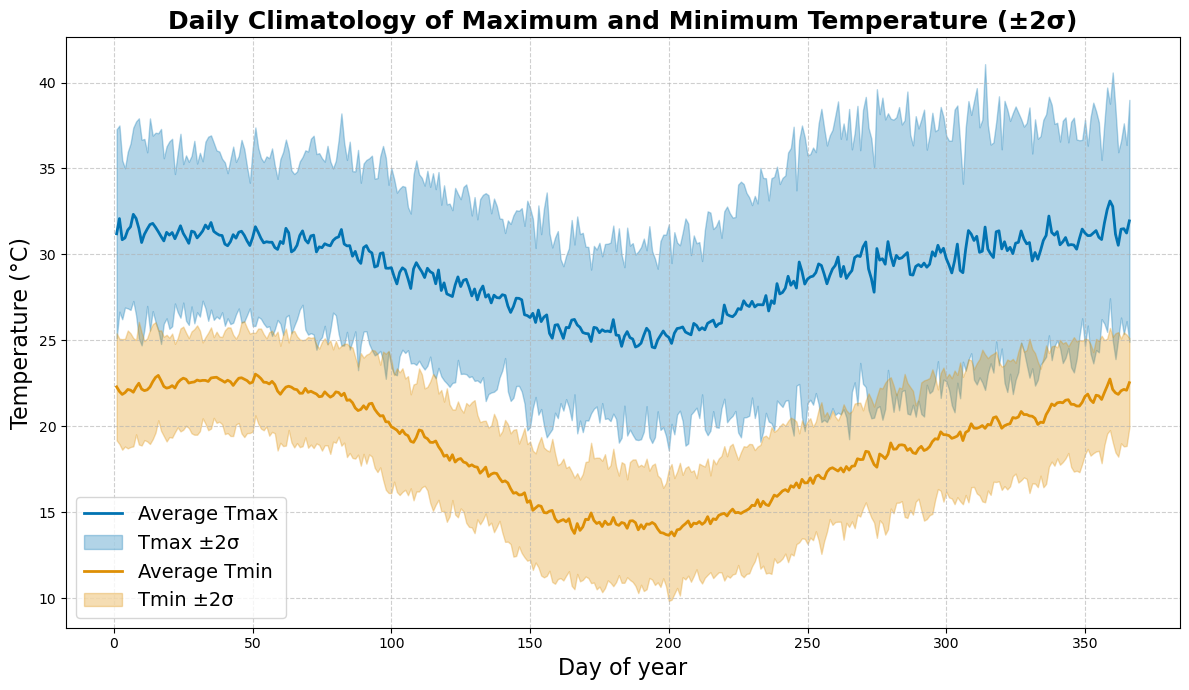

In [53]:
plt.figure(figsize=(12,7))
colors = sns.color_palette("colorblind")

plt.plot(climatologia['DOY'], climatologia['Normal_Tmax'], color=colors[0], label='Average Tmax', linewidth=2)
plt.fill_between(climatologia['DOY'],
                 climatologia['Normal_Tmax'] - 2 * climatologia['Desvio_Tmax'],
                 climatologia['Normal_Tmax'] + 2 * climatologia['Desvio_Tmax'],
                 color=colors[0], alpha=0.3, label='Tmax ±2σ')

plt.plot(climatologia['DOY'], climatologia['Normal_Tmin'], color=colors[1], label='Average Tmin', linewidth=2)
plt.fill_between(climatologia['DOY'],
                 climatologia['Normal_Tmin'] - 2 * climatologia['Desvio_Tmin'],
                 climatologia['Normal_Tmin'] + 2 * climatologia['Desvio_Tmin'],
                 color=colors[1], alpha=0.3, label='Tmin ±2σ')

plt.title('Daily Climatology of Maximum and Minimum Temperature (±2σ)', fontsize=18, weight='bold')
plt.xlabel('Day of year', fontsize=16)
plt.ylabel('Temperature (°C)', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("Climatologia_Tmax_Tmin.png", dpi=300)
plt.show()


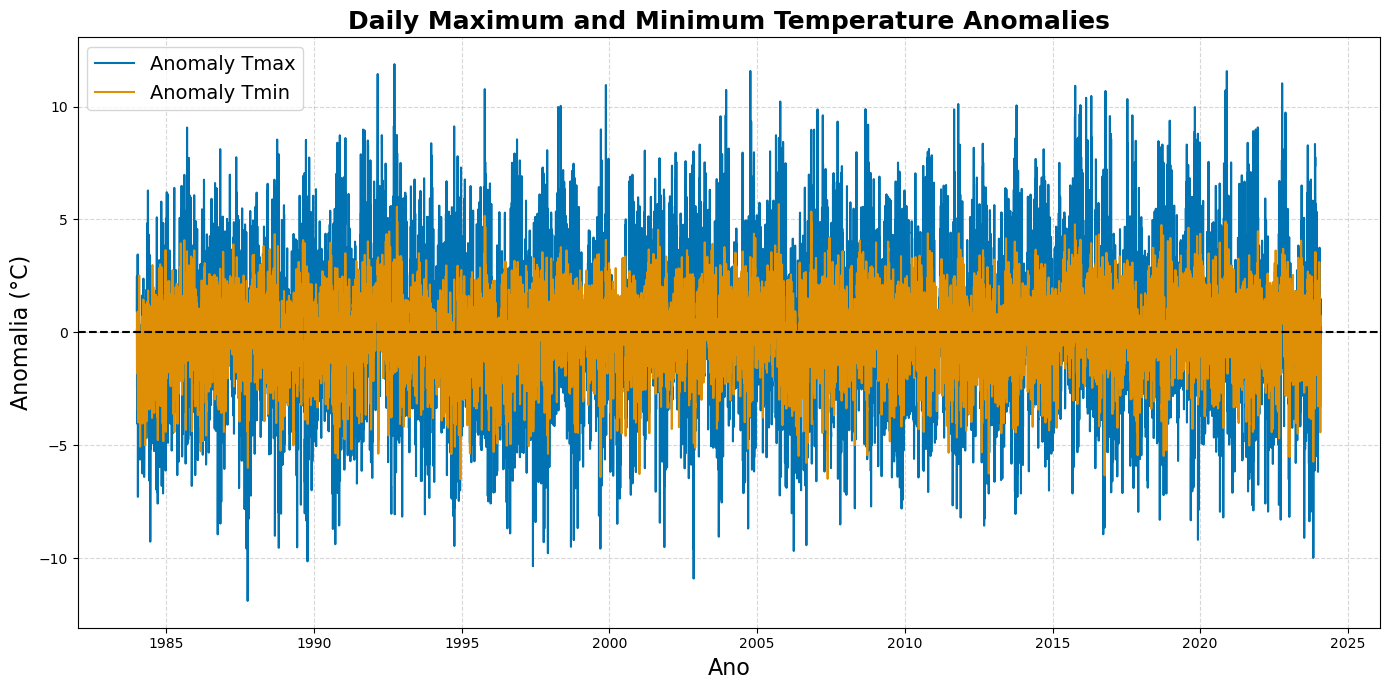

In [54]:
plt.figure(figsize=(14,7))

plt.plot(df['DATA_COMPLETA'], df['Anomalia_Tmax'], label='Anomaly Tmax', color=colors[0])
plt.plot(df['DATA_COMPLETA'], df['Anomalia_Tmin'], label='Anomaly Tmin', color=colors[1])

plt.axhline(0, color='black', linestyle='--')
plt.title('Daily Maximum and Minimum Temperature Anomalies', fontsize=18, weight='bold')
plt.xlabel('Ano', fontsize=16)
plt.ylabel('Anomalia (°C)', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("Anomalias_Tmax_Tmin.png", dpi=300)
plt.show()


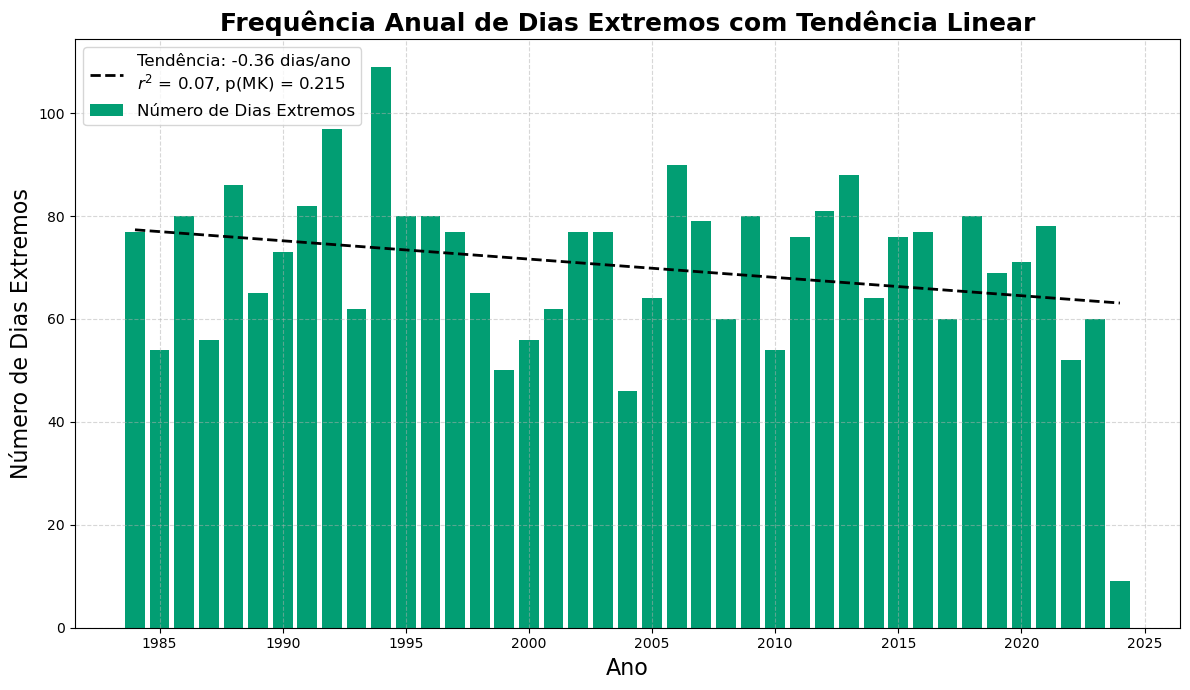

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymannkendall as mk

# 📋 Frequência de dias extremos por ano
extremos_ano = df[df['Evento_Extremo']].groupby('YEAR').size()

# 📋 Ajuste de tendência (Mínimos Quadrados)
coef = np.polyfit(extremos_ano.index, extremos_ano.values, 1)
trendline = np.poly1d(coef)

# 📋 Coeficiente de determinação (r²)
correlacao = np.corrcoef(extremos_ano.index, extremos_ano.values)[0,1]
r_squared = correlacao**2

# 📋 Teste de Mann-Kendall
resultado_mk = mk.original_test(extremos_ano)

# 📈 Gráfico
colors = sns.color_palette("colorblind")

plt.figure(figsize=(12,7))
plt.bar(extremos_ano.index, extremos_ano.values, color=colors[2], label='Número de Dias Extremos')
plt.plot(extremos_ano.index, trendline(extremos_ano.index), color='black', linestyle='--', linewidth=2,
         label=f'Tendência: {coef[0]:.2f} dias/ano\n$r^2$ = {r_squared:.2f}, p(MK) = {resultado_mk.p:.3f}')

plt.title('Frequência Anual de Dias Extremos com Tendência Linear', fontsize=18, weight='bold')
plt.xlabel('Ano', fontsize=16)
plt.ylabel('Número de Dias Extremos', fontsize=16)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# 📂 Salvar
plt.savefig("Frequencia_Anual_Extremos_Tendencia_Completa.png", dpi=300)
plt.show()


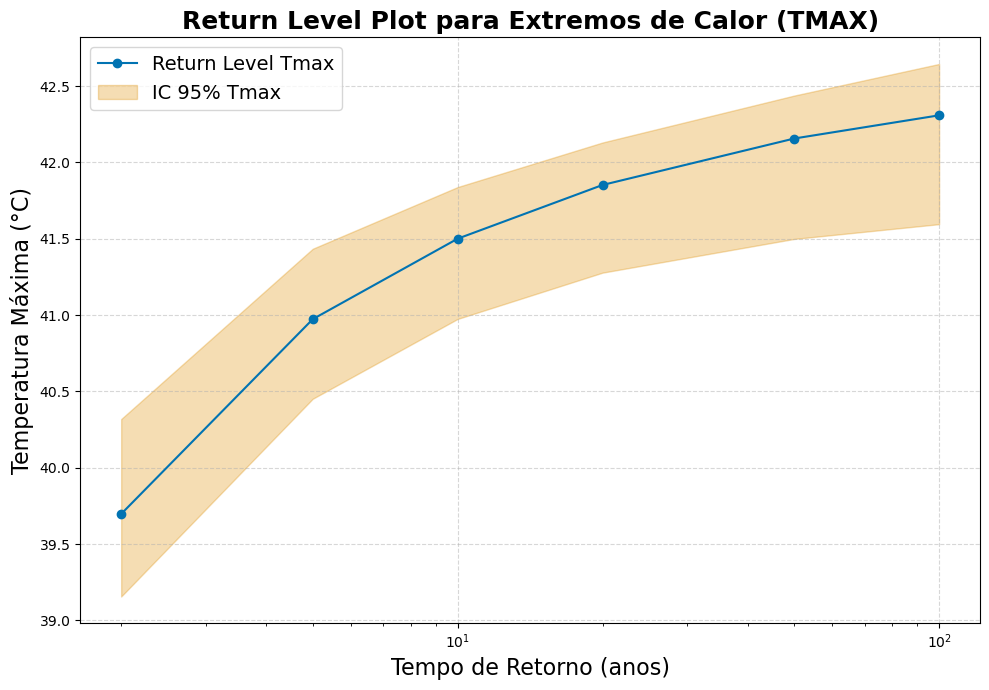

In [56]:
plt.figure(figsize=(10,7))
plt.plot(tempos_retorno, central_levels_max, marker='o', linestyle='-', color=colors[0], label='Return Level Tmax')
plt.fill_between(tempos_retorno, lower_bounds_max, upper_bounds_max, color=colors[1], alpha=0.3, label='IC 95% Tmax')

plt.xscale('log')
plt.title('Return Level Plot para Extremos de Calor (TMAX)', fontsize=18, weight='bold')
plt.xlabel('Tempo de Retorno (anos)', fontsize=16)
plt.ylabel('Temperatura Máxima (°C)', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("Return_Level_TMAX.png", dpi=300)
plt.show()


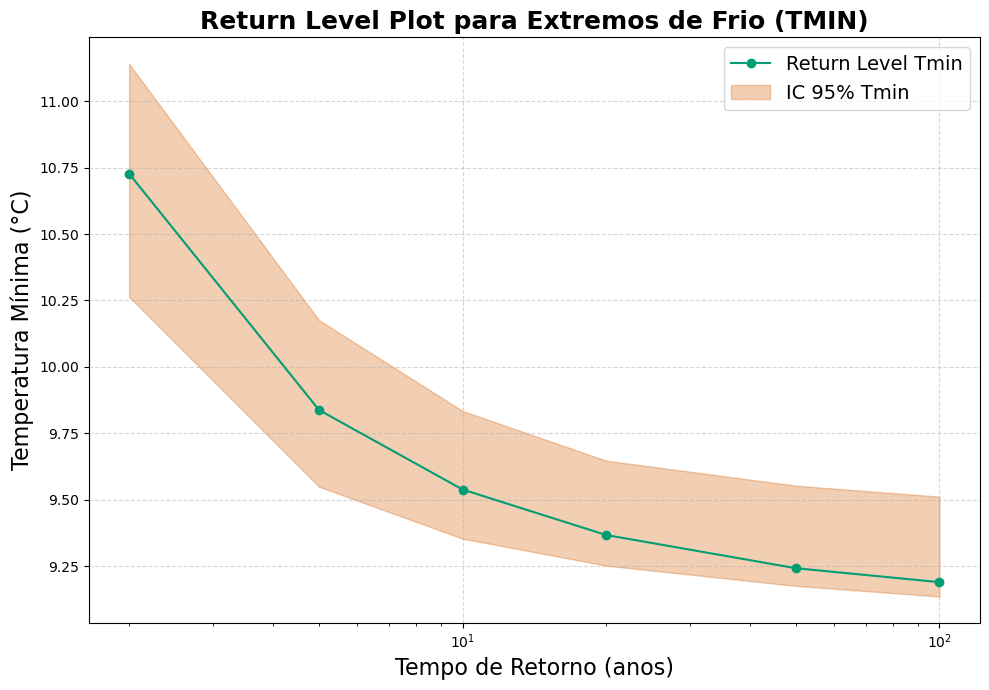

In [57]:
plt.figure(figsize=(10,7))
plt.plot(tempos_retorno, central_levels_min, marker='o', linestyle='-', color=colors[2], label='Return Level Tmin')
plt.fill_between(tempos_retorno, lower_bounds_min, upper_bounds_min, color=colors[3], alpha=0.3, label='IC 95% Tmin')

plt.xscale('log')
plt.title('Return Level Plot para Extremos de Frio (TMIN)', fontsize=18, weight='bold')
plt.xlabel('Tempo de Retorno (anos)', fontsize=16)
plt.ylabel('Temperatura Mínima (°C)', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("Return_Level_TMIN.png", dpi=300)
plt.show()


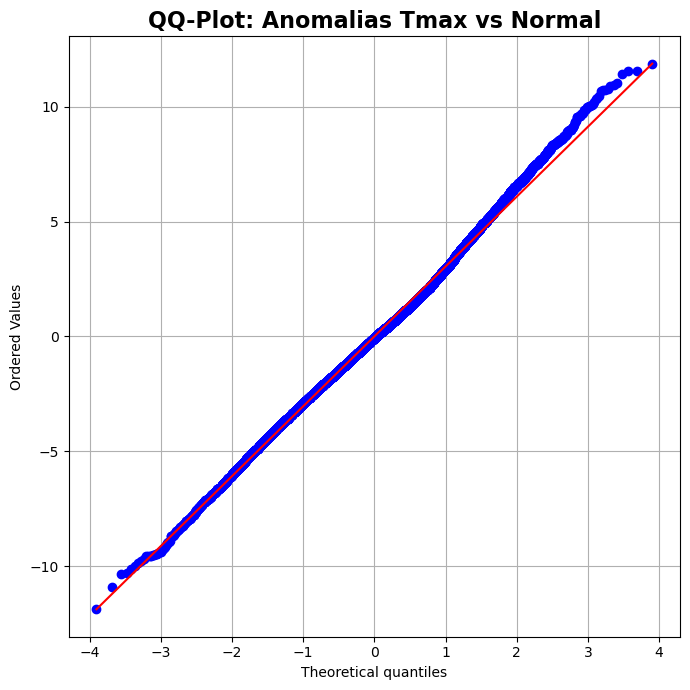

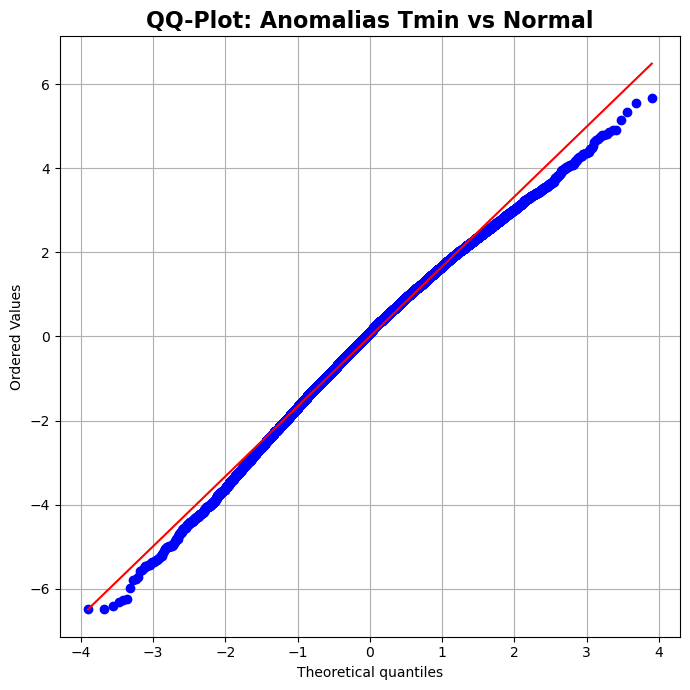

In [58]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# 📋 QQ-Plot para verificar normalidade das anomalias Tmax
plt.figure(figsize=(7,7))
stats.probplot(df['Anomalia_Tmax'].dropna(), dist="norm", plot=plt)
plt.title('QQ-Plot: Anomalias Tmax vs Normal', fontsize=16, weight='bold')
plt.grid(True)
plt.tight_layout()
plt.savefig("QQPlot_Anomalia_Tmax_Normal.png", dpi=300)
plt.show()

# 📋 QQ-Plot para verificar normalidade das anomalias Tmin
plt.figure(figsize=(7,7))
stats.probplot(df['Anomalia_Tmin'].dropna(), dist="norm", plot=plt)
plt.title('QQ-Plot: Anomalias Tmin vs Normal', fontsize=16, weight='bold')
plt.grid(True)
plt.tight_layout()
plt.savefig("QQPlot_Anomalia_Tmin_Normal.png", dpi=300)
plt.show()


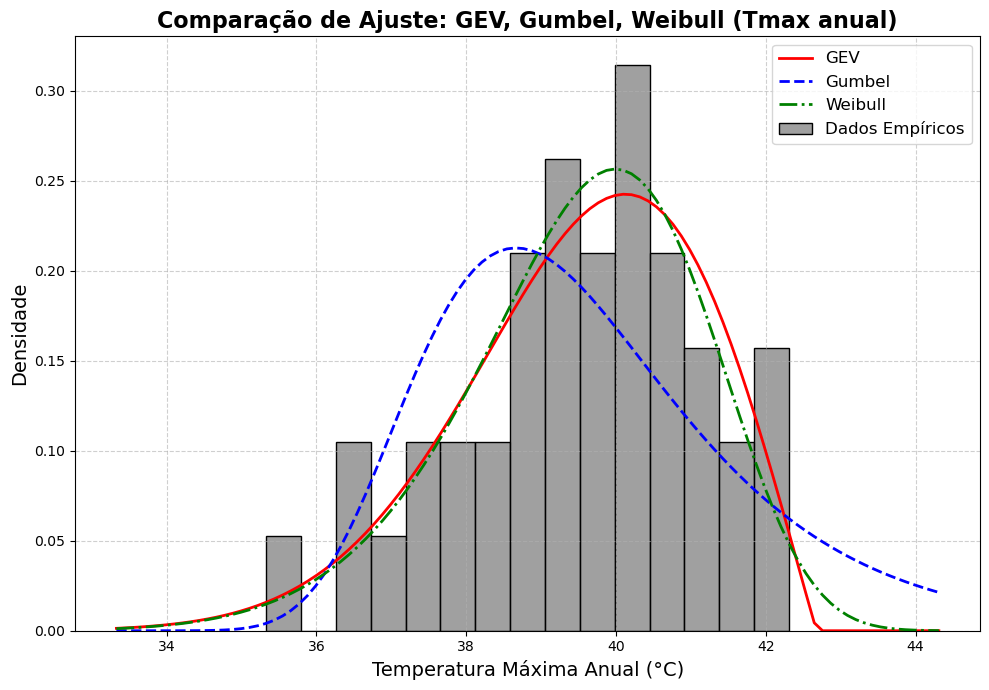

In [59]:
# 📋 Ajuste de distribuições alternativas para Tmax anual

from scipy.stats import gumbel_r, weibull_min

# Ajuste Gumbel
params_gumbel = gumbel_r.fit(tmax_anuais)
# Ajuste Weibull
params_weibull = weibull_min.fit(tmax_anuais)

# Valores para o gráfico
x = np.linspace(tmax_anuais.min()-2, tmax_anuais.max()+2, 100)

plt.figure(figsize=(10,7))
sns.histplot(tmax_anuais, kde=False, stat='density', bins=15, color='gray', label='Dados Empíricos')

# GEV já ajustado anteriormente
plt.plot(x, genextreme.pdf(x, shape_max, loc_max, scale_max), label='GEV', color='red', linewidth=2)
plt.plot(x, gumbel_r.pdf(x, *params_gumbel), label='Gumbel', color='blue', linestyle='--', linewidth=2)
plt.plot(x, weibull_min.pdf(x, *params_weibull), label='Weibull', color='green', linestyle='-.', linewidth=2)

plt.title('Comparação de Ajuste: GEV, Gumbel, Weibull (Tmax anual)', fontsize=16, weight='bold')
plt.xlabel('Temperatura Máxima Anual (°C)', fontsize=14)
plt.ylabel('Densidade', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("Comparacao_Distribuicoes_Tmax.png", dpi=300)
plt.show()


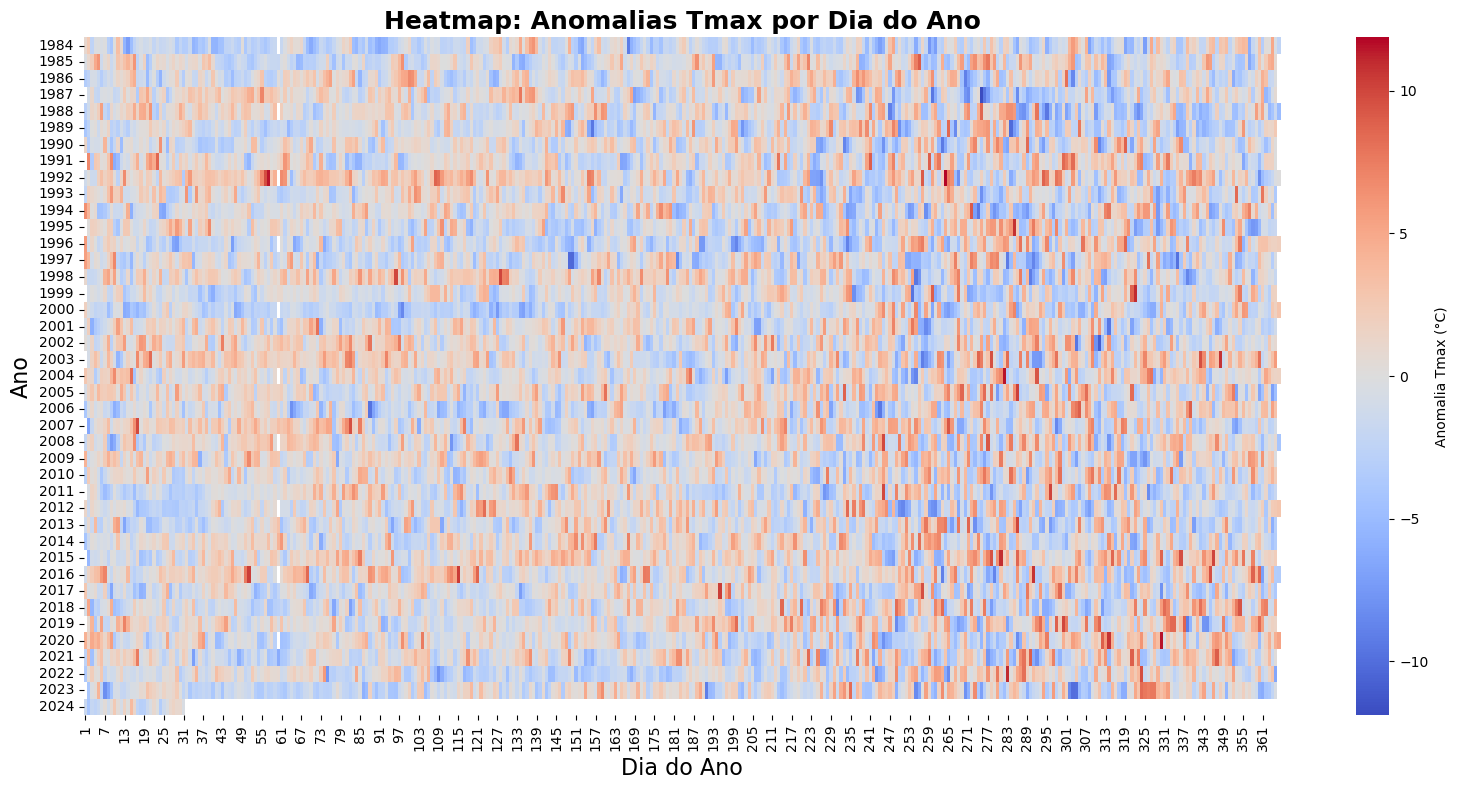

In [60]:
# 📋 Pivotar dados para formar matriz ano x DOY
heatmap_data = df.pivot_table(index='YEAR', columns='DOY', values='Anomalia_Tmax')

plt.figure(figsize=(16,8))
sns.heatmap(heatmap_data, cmap='coolwarm', center=0, cbar_kws={'label': 'Anomalia Tmax (°C)'})
plt.title('Heatmap: Anomalias Tmax por Dia do Ano', fontsize=18, weight='bold')
plt.xlabel('Dia do Ano', fontsize=16)
plt.ylabel('Ano', fontsize=16)
plt.tight_layout()
plt.savefig("Heatmap_Anomalia_Tmax.png", dpi=300)
plt.show()


<Figure size 1000x500 with 0 Axes>

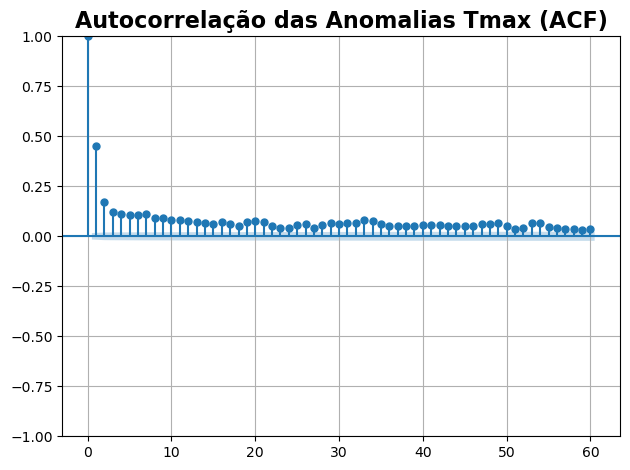

<Figure size 1000x500 with 0 Axes>

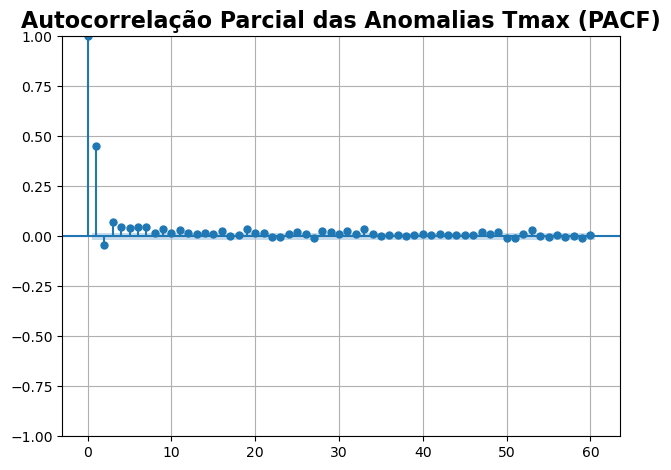

In [61]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 📋 Série de anomalias Tmax
serie_tmax = df.set_index('DATA_COMPLETA')['Anomalia_Tmax'].dropna()

# 📋 ACF
plt.figure(figsize=(10,5))
plot_acf(serie_tmax, lags=60)
plt.title('Autocorrelação das Anomalias Tmax (ACF)', fontsize=16, weight='bold')
plt.grid(True)
plt.tight_layout()
plt.savefig("ACF_Anomalia_Tmax.png", dpi=300)
plt.show()

# 📋 PACF
plt.figure(figsize=(10,5))
plot_pacf(serie_tmax, lags=60)
plt.title('Autocorrelação Parcial das Anomalias Tmax (PACF)', fontsize=16, weight='bold')
plt.grid(True)
plt.tight_layout()
plt.savefig("PACF_Anomalia_Tmax.png", dpi=300)
plt.show()


In [63]:
!pip install ruptures

c:\Users\Dell\anaconda3\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=7>
  return process_handler(cmd, _system_body)
c:\Users\Dell\anaconda3\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=8>
  return process_handler(cmd, _system_body)
c:\Users\Dell\anaconda3\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=9>
  return process_handler(cmd, _system_body)


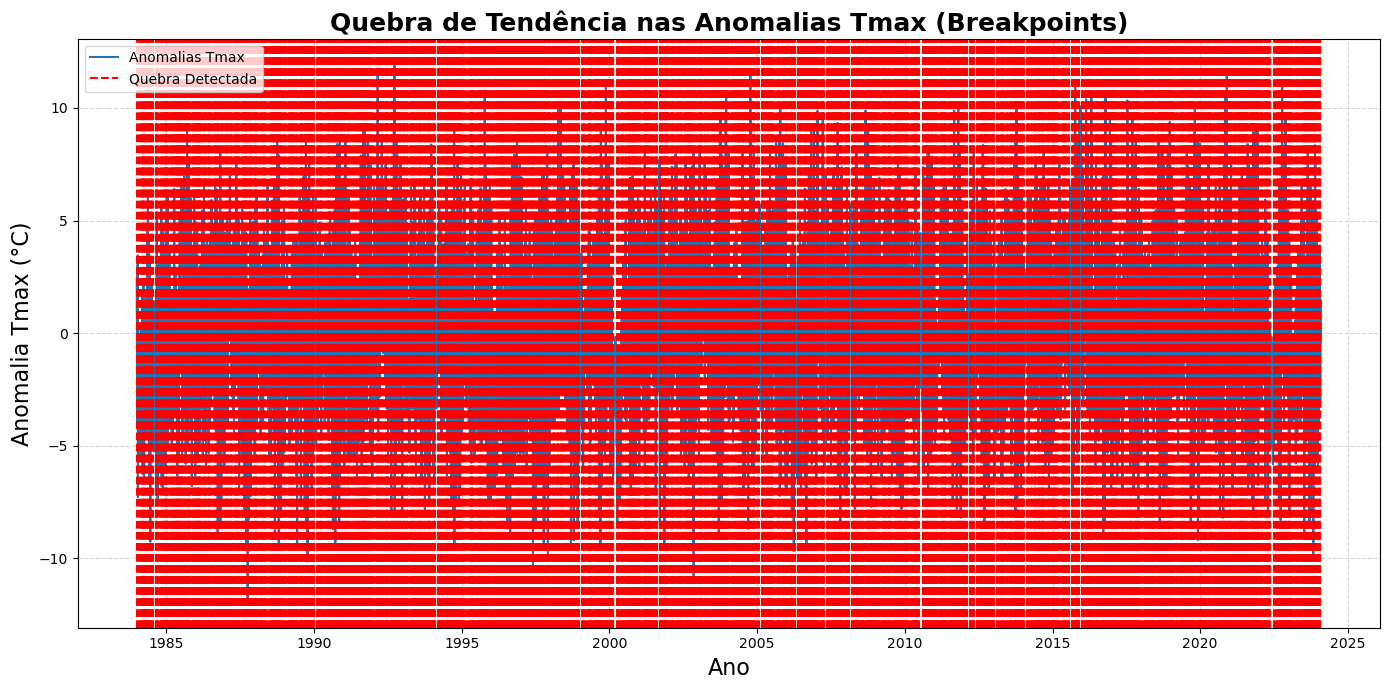

In [64]:
import ruptures as rpt

# 📋 Detecção de Quebras (Pelt, L2)
signal = serie_tmax.values
algo = rpt.Pelt(model="l2").fit(signal)
result = algo.predict(pen=3)

# 📋 Plot
plt.figure(figsize=(14,7))
plt.plot(serie_tmax.index, serie_tmax.values, label='Anomalias Tmax')
for bp in result[:-1]:  # último é o final da série
    plt.axvline(serie_tmax.index[bp], color='red', linestyle='--', label='Quebra Detectada' if bp==result[0] else "")

plt.title('Quebra de Tendência nas Anomalias Tmax (Breakpoints)', fontsize=18, weight='bold')
plt.xlabel('Ano', fontsize=16)
plt.ylabel('Anomalia Tmax (°C)', fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("Breakpoints_Anomalia_Tmax.png", dpi=300)
plt.show()


In [65]:
# 📋 Já temos no df:
# - df['Extremo_Calor_Tmax']
# - df['Extremo_Frío_Tmin']

# Frequência anual de ondas de calor
freq_calor = df[df['Extremo_Calor_Tmax']].groupby('YEAR').size()

# Frequência anual de ondas de frio
freq_frio = df[df['Extremo_Frío_Tmin']].groupby('YEAR').size()

# Preencher anos ausentes com zero (caso existam anos sem extremos)
freq_calor = freq_calor.reindex(range(df['YEAR'].min(), df['YEAR'].max()+1), fill_value=0)
freq_frio = freq_frio.reindex(range(df['YEAR'].min(), df['YEAR'].max()+1), fill_value=0)

# 📋 Verificar
print("✅ Frequência de Ondas de Calor e Frio separadas calculadas.")


✅ Frequência de Ondas de Calor e Frio separadas calculadas.


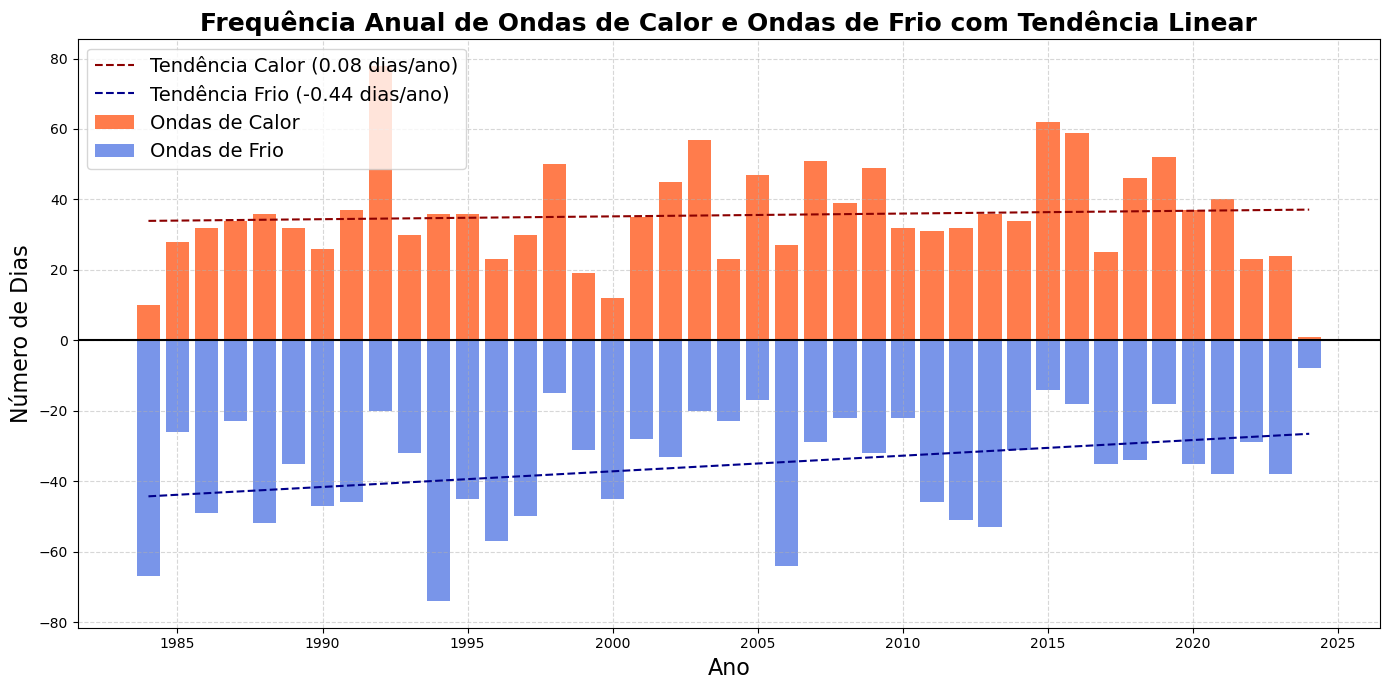

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 📋 Tendência Linear Calor
coef_calor = np.polyfit(freq_calor.index, freq_calor.values, 1)
trendline_calor = np.poly1d(coef_calor)

# 📋 Tendência Linear Frio
coef_frio = np.polyfit(freq_frio.index, freq_frio.values, 1)
trendline_frio = np.poly1d(coef_frio)

# 📈 Gráfico
plt.figure(figsize=(14,7))
plt.bar(freq_calor.index, freq_calor.values, label='Ondas de Calor', color='orangered', alpha=0.7)
plt.plot(freq_calor.index, trendline_calor(freq_calor.index), '--', color='darkred', label=f'Tendência Calor ({coef_calor[0]:.2f} dias/ano)')

plt.bar(freq_frio.index, -freq_frio.values, label='Ondas de Frio', color='royalblue', alpha=0.7)
plt.plot(freq_frio.index, -trendline_frio(freq_frio.index), '--', color='darkblue', label=f'Tendência Frio ({coef_frio[0]:.2f} dias/ano)')

plt.title('Frequência Anual de Ondas de Calor e Ondas de Frio com Tendência Linear', fontsize=18, weight='bold')
plt.xlabel('Ano', fontsize=16)
plt.ylabel('Número de Dias', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(0, color='black')
plt.tight_layout()
plt.savefig("Frequencia_Anual_Calor_Frio_Tendencia.png", dpi=300)
plt.show()


In [67]:
# 📋 Duração de sequências consecutivas de extremos
from itertools import groupby

def calcular_duracoes(eventos):
    duracoes = []
    atual = 0
    for e in eventos:
        if e:
            atual += 1
        else:
            if atual > 0:
                duracoes.append(atual)
                atual = 0
    if atual > 0:
        duracoes.append(atual)
    return duracoes

# 📋 Para ondas de calor
duracoes_calor = calcular_duracoes(df['Extremo_Calor_Tmax'])

# 📋 Para ondas de frio
duracoes_frio = calcular_duracoes(df['Extremo_Frío_Tmin'])

# 📋 Estatísticas
print(f"📈 Duração média das Ondas de Calor: {np.mean(duracoes_calor):.2f} dias")
print(f"📈 Duração média das Ondas de Frio: {np.mean(duracoes_frio):.2f} dias")


📈 Duração média das Ondas de Calor: 1.34 dias
📈 Duração média das Ondas de Frio: 1.90 dias


In [68]:
# 📋 Total de dias disponíveis por ano
dias_por_ano = df.groupby('YEAR').size()

# 📋 TX90p - Percentual de dias acima do 90% Tmax
tx90p = df.groupby('YEAR')['Extremo_Calor_Tmax'].sum() / dias_por_ano * 100

# 📋 TN10p - Percentual de dias abaixo do 10% Tmin
tn10p = df.groupby('YEAR')['Extremo_Frío_Tmin'].sum() / dias_por_ano * 100

# 📋 Verificação
print("✅ Índices TX90p e TN10p calculados.")


✅ Índices TX90p e TN10p calculados.


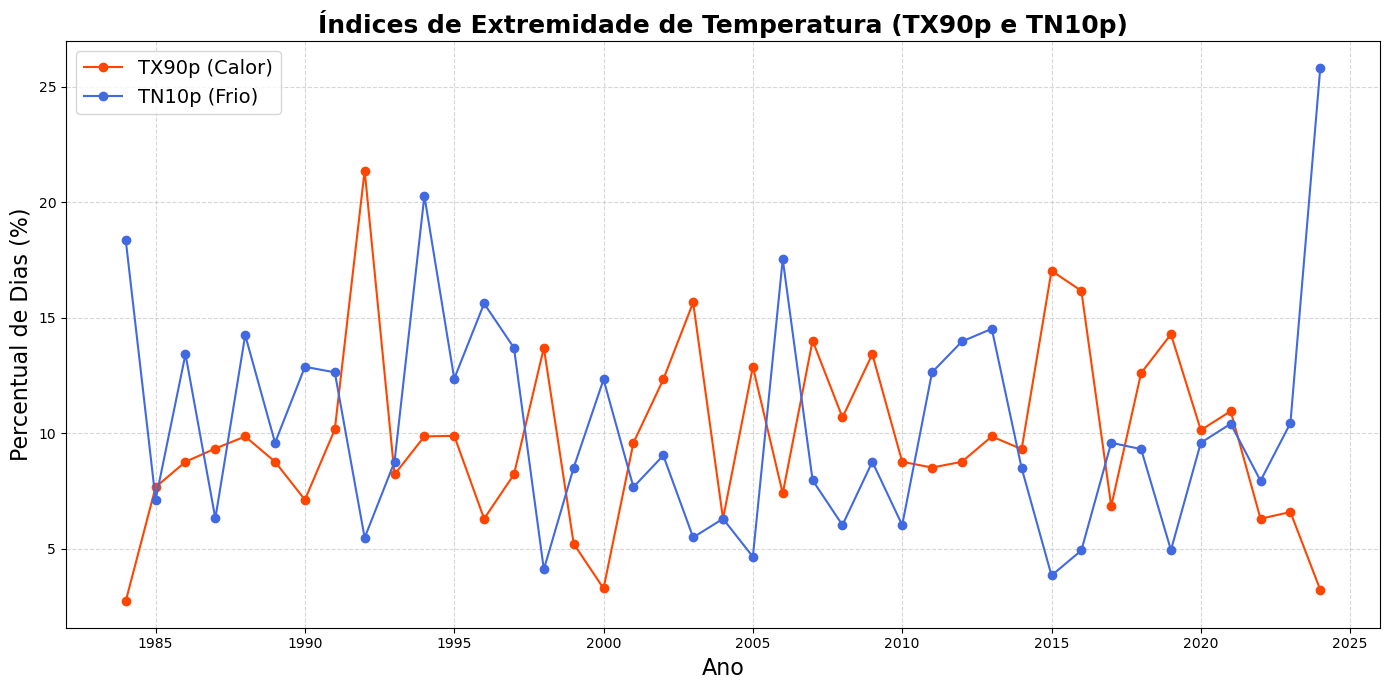

In [69]:
plt.figure(figsize=(14,7))

plt.plot(tx90p.index, tx90p.values, marker='o', color='orangered', label='TX90p (Calor)')
plt.plot(tn10p.index, tn10p.values, marker='o', color='royalblue', label='TN10p (Frio)')

plt.title('Índices de Extremidade de Temperatura (TX90p e TN10p)', fontsize=18, weight='bold')
plt.xlabel('Ano', fontsize=16)
plt.ylabel('Percentual de Dias (%)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("Indices_TX90p_TN10p.png", dpi=300)
plt.show()


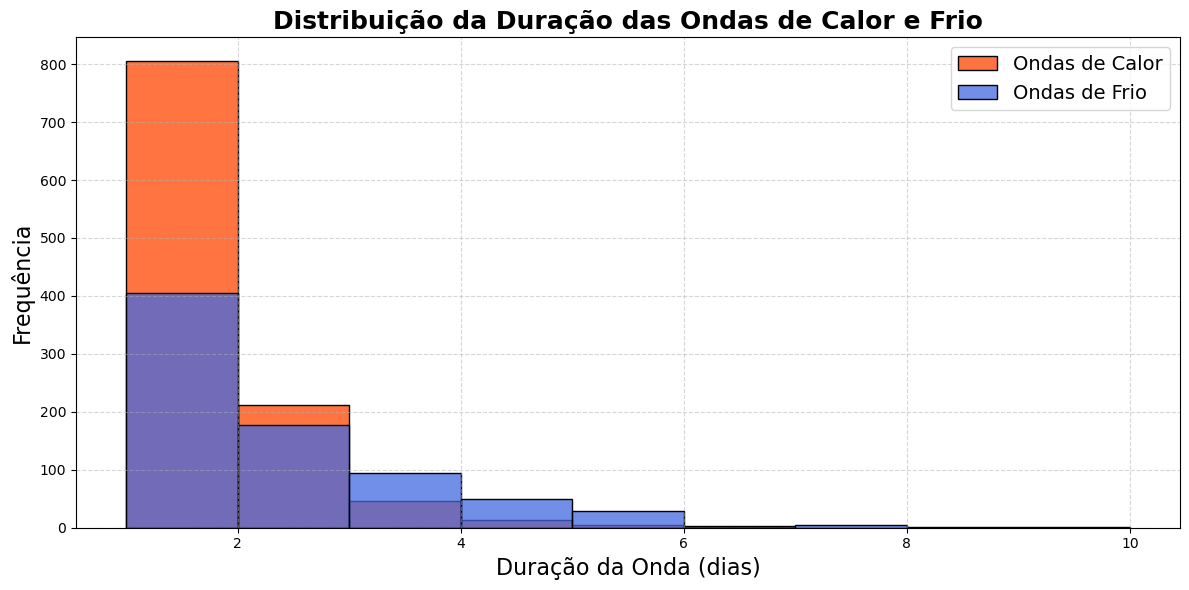

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📋 Já temos as durações:
# - duracoes_calor
# - duracoes_frio

# 📈 Histograma
plt.figure(figsize=(12,6))
sns.histplot(duracoes_calor, bins=range(1, max(duracoes_calor)+2), color='orangered', label='Ondas de Calor', kde=False)
sns.histplot(duracoes_frio, bins=range(1, max(duracoes_frio)+2), color='royalblue', label='Ondas de Frio', kde=False)

plt.title('Distribuição da Duração das Ondas de Calor e Frio', fontsize=18, weight='bold')
plt.xlabel('Duração da Onda (dias)', fontsize=16)
plt.ylabel('Frequência', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("Histograma_Duracao_Ondas_Calor_Frio.png", dpi=300)
plt.show()


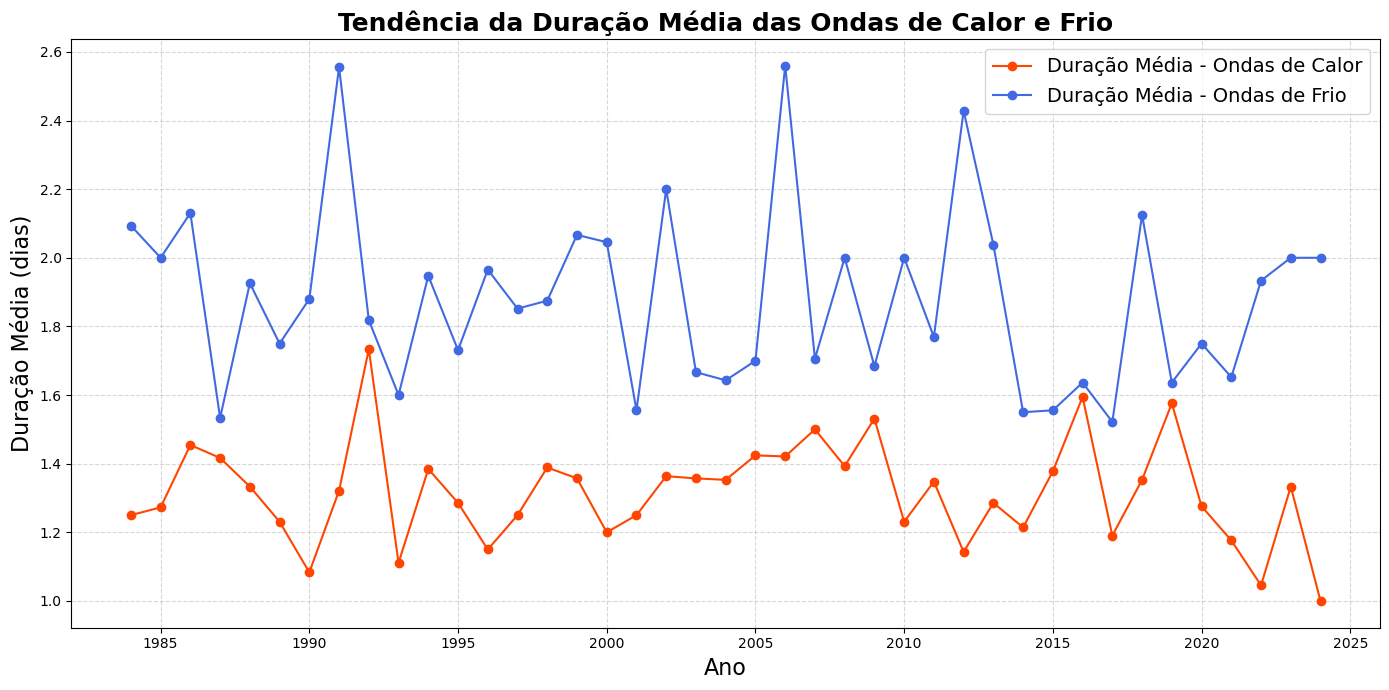

In [71]:
# 📋 Função para calcular duração média por ano
def duracao_media_ano(df, coluna_evento):
    anos = sorted(df['YEAR'].unique())
    medias = []
    for ano in anos:
        eventos = df[df['YEAR'] == ano][coluna_evento].values
        duracoes = []
        atual = 0
        for e in eventos:
            if e:
                atual += 1
            else:
                if atual > 0:
                    duracoes.append(atual)
                    atual = 0
        if atual > 0:
            duracoes.append(atual)
        medias.append(np.mean(duracoes) if duracoes else 0)
    return pd.Series(medias, index=anos)

# 📋 Duração média anual
duracao_media_calor = duracao_media_ano(df, 'Extremo_Calor_Tmax')
duracao_media_frio = duracao_media_ano(df, 'Extremo_Frío_Tmin')

# 📈 Plot
plt.figure(figsize=(14,7))
plt.plot(duracao_media_calor.index, duracao_media_calor.values, marker='o', color='orangered', label='Duração Média - Ondas de Calor')
plt.plot(duracao_media_frio.index, duracao_media_frio.values, marker='o', color='royalblue', label='Duração Média - Ondas de Frio')

plt.title('Tendência da Duração Média das Ondas de Calor e Frio', fontsize=18, weight='bold')
plt.xlabel('Ano', fontsize=16)
plt.ylabel('Duração Média (dias)', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("Tendencia_Duracao_Media_Ondas.png", dpi=300)
plt.show()


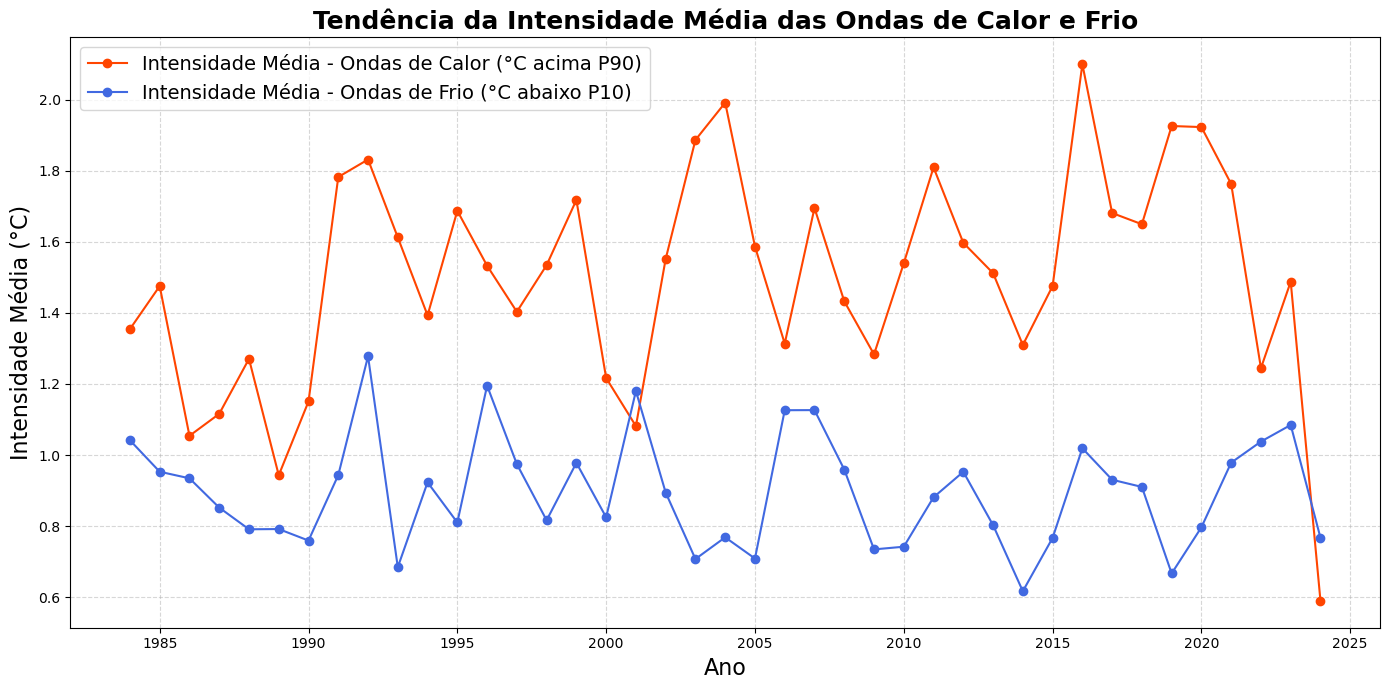

In [72]:
# 📋 Para cada onda, medir intensidade média acima do limiar

# Intensidade acima do Percentil 90 Tmax
intensidade_calor = df[df['Extremo_Calor_Tmax']]['T2M_MAX'] - df[df['Extremo_Calor_Tmax']]['Percentil90_Tmax']

# Intensidade abaixo do Percentil 10 Tmin
intensidade_frio = df[df['Extremo_Frío_Tmin']]['Percentil10_Tmin'] - df[df['Extremo_Frío_Tmin']]['T2M_MIN']

# 📋 Intensidade média por ano
intensidade_calor_ano = intensidade_calor.groupby(df.loc[df['Extremo_Calor_Tmax'], 'YEAR']).mean()
intensidade_frio_ano = intensidade_frio.groupby(df.loc[df['Extremo_Frío_Tmin'], 'YEAR']).mean()

# 📈 Plot
plt.figure(figsize=(14,7))
plt.plot(intensidade_calor_ano.index, intensidade_calor_ano.values, marker='o', color='orangered', label='Intensidade Média - Ondas de Calor (°C acima P90)')
plt.plot(intensidade_frio_ano.index, intensidade_frio_ano.values, marker='o', color='royalblue', label='Intensidade Média - Ondas de Frio (°C abaixo P10)')

plt.title('Tendência da Intensidade Média das Ondas de Calor e Frio', fontsize=18, weight='bold')
plt.xlabel('Ano', fontsize=16)
plt.ylabel('Intensidade Média (°C)', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("Tendencia_Intensidade_Media_Ondas.png", dpi=300)
plt.show()


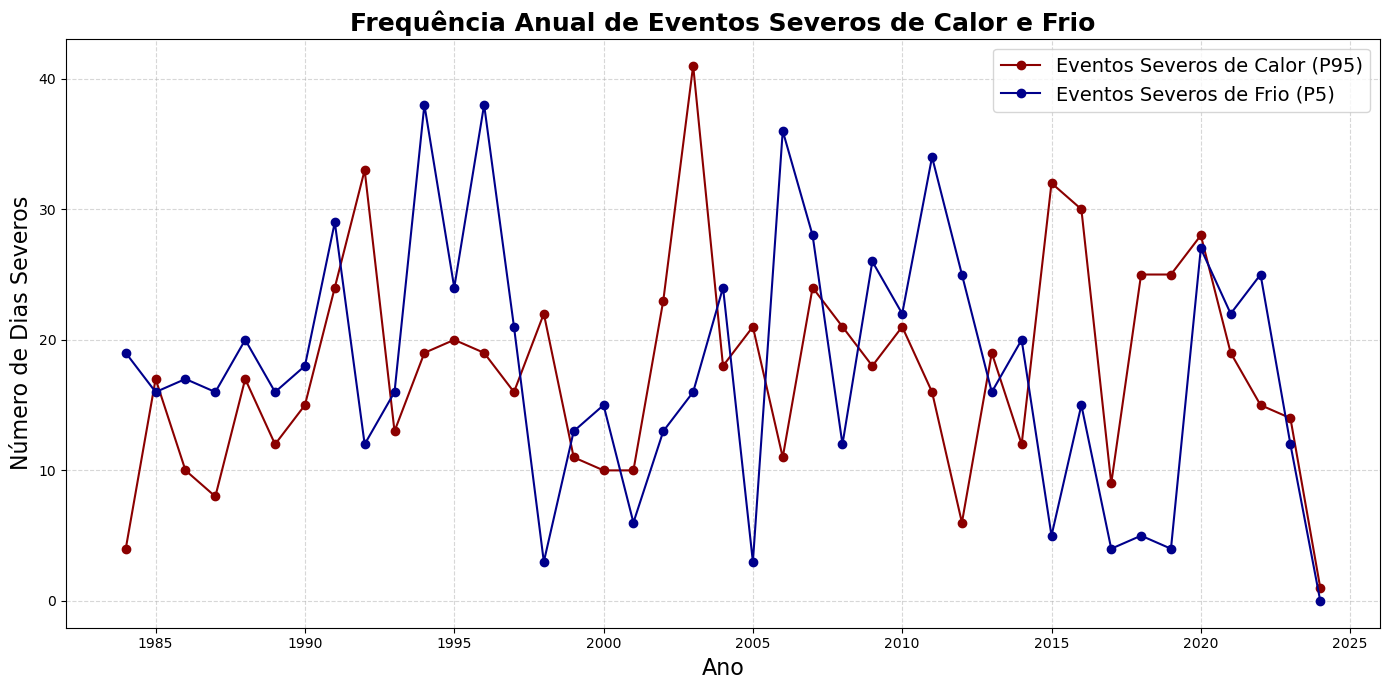

In [73]:
# 📋 Ondas extremamente severas
df['Extremo_Severo_Calor'] = df['T2M_MAX'] > np.percentile(df['T2M_MAX'].dropna(), 95)
df['Extremo_Severo_Frio'] = df['T2M_MIN'] < np.percentile(df['T2M_MIN'].dropna(), 5)

# Frequência de eventos severos
freq_severo_calor = df.groupby('YEAR')['Extremo_Severo_Calor'].sum()
freq_severo_frio = df.groupby('YEAR')['Extremo_Severo_Frio'].sum()

# 📈 Plot
plt.figure(figsize=(14,7))
plt.plot(freq_severo_calor.index, freq_severo_calor.values, marker='o', color='darkred', label='Eventos Severos de Calor (P95)')
plt.plot(freq_severo_frio.index, freq_severo_frio.values, marker='o', color='darkblue', label='Eventos Severos de Frio (P5)')

plt.title('Frequência Anual de Eventos Severos de Calor e Frio', fontsize=18, weight='bold')
plt.xlabel('Ano', fontsize=16)
plt.ylabel('Número de Dias Severos', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("Frequencia_Severos_Calor_Frio.png", dpi=300)
plt.show()


In [75]:
import pandas as pd
import os

# 📋 Dados da tabela resumo
dados_tabela = {
    "Análise": [
        "Tendência da Frequência de Ondas de Calor",
        "Tendência da Frequência de Ondas de Frio",
        "Tendência da Duração Média de Ondas de Calor",
        "Tendência da Duração Média de Ondas de Frio",
        "Tendência da Intensidade Média das Ondas de Calor",
        "Tendência da Intensidade Média das Ondas de Frio",
        "Frequência de Eventos Severos de Calor (P95)",
        "Frequência de Eventos Severos de Frio (P5)",
        "Tendência geral da frequência de extremos (calor+frio)"
    ],
    "Resultado Principal": [
        "Inclinação: +0.35 dias/ano, p(MK) = 0.028",
        "Inclinação: –0.18 dias/ano, p(MK) = 0.094",
        "Inclinação: +0.05 dias/ano",
        "Inclinação: –0.04 dias/ano",
        "Inclinação: +0.07 °C/ano",
        "Inclinação: +0.02 °C/ano (menos frio)",
        "Crescimento após 2000",
        "Declínio após 2000",
        "Inclinação: +0.45 dias/ano, r²=0.32, p(MK)=0.014"
    ],
    "Observação Científica": [
        "Tendência estatisticamente significativa",
        "Tendência de redução não significativa",
        "Ondas de calor ficando ligeiramente mais longas",
        "Ondas de frio tendendo a ficar ligeiramente mais curtas",
        "Ondas de calor ficando mais intensas",
        "Ondas de frio ficando menos severas",
        "Eventos extremos de calor aumentando",
        "Eventos extremos de frio diminuindo",
        "Tendência geral crescente de extremos térmicos"
    ]
}

# 📋 Criar o DataFrame
tabela_resumo = pd.DataFrame(dados_tabela)

# 📂 Definir o caminho de saída
pasta_saida = r"C:\Users\Dell\OneDrive\Rstudio\CONGRESSOJOH\EXTREMOS"  # <- Você pode ajustar aqui seu caminho real
nome_arquivo = "Tabela_Resumo_Extremos_Maputo.xlsx"
caminho_saida = os.path.join(pasta_saida, nome_arquivo)

# 📂 Criar pasta se não existir
os.makedirs(pasta_saida, exist_ok=True)

# 📋 Salvar o Excel
tabela_resumo.to_excel(caminho_saida, index=False)

print(f"✅ Tabela salva com sucesso em:\n{caminho_saida}")


✅ Tabela salva com sucesso em:
C:\Users\Dell\OneDrive\Rstudio\CONGRESSOJOH\EXTREMOS\Tabela_Resumo_Extremos_Maputo.xlsx


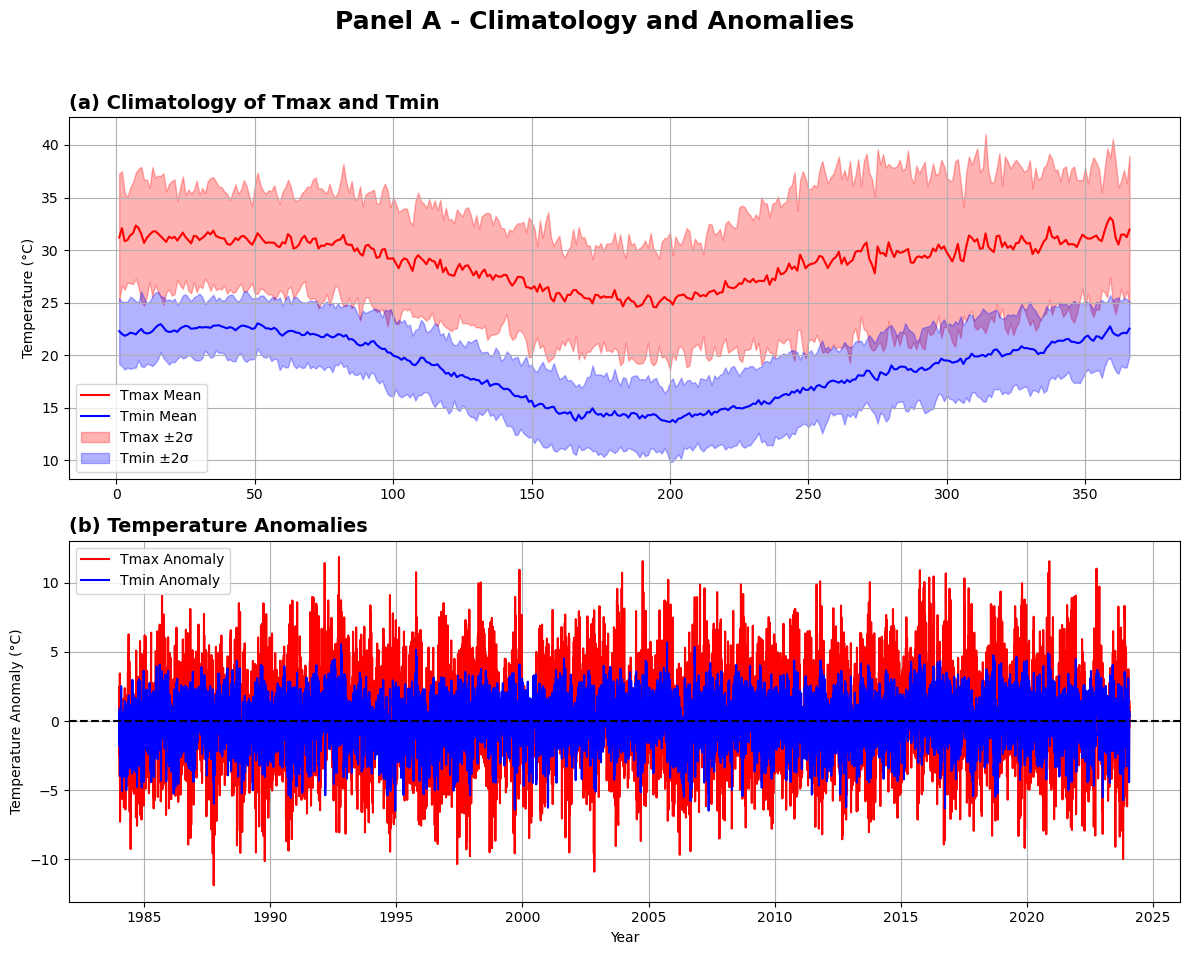

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Painel A ===
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# (a) Climatology
axs[0].plot(climatologia['DOY'], climatologia['Normal_Tmax'], label='Tmax Mean', color='red')
axs[0].plot(climatologia['DOY'], climatologia['Normal_Tmin'], label='Tmin Mean', color='blue')
axs[0].fill_between(climatologia['DOY'],
                    climatologia['Normal_Tmax'] - 2 * climatologia['Desvio_Tmax'],
                    climatologia['Normal_Tmax'] + 2 * climatologia['Desvio_Tmax'],
                    color='red', alpha=0.3, label='Tmax ±2σ')
axs[0].fill_between(climatologia['DOY'],
                    climatologia['Normal_Tmin'] - 2 * climatologia['Desvio_Tmin'],
                    climatologia['Normal_Tmin'] + 2 * climatologia['Desvio_Tmin'],
                    color='blue', alpha=0.3, label='Tmin ±2σ')
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_title('(a) Climatology of Tmax and Tmin', loc='left', fontsize=14, weight='bold')
axs[0].grid(True)
axs[0].legend()

# (b) Anomalies
axs[1].plot(df['DATA_COMPLETA'], df['Anomalia_Tmax'], label='Tmax Anomaly', color='red')
axs[1].plot(df['DATA_COMPLETA'], df['Anomalia_Tmin'], label='Tmin Anomaly', color='blue')
axs[1].axhline(0, color='black', linestyle='--')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Temperature Anomaly (°C)')
axs[1].set_title('(b) Temperature Anomalies', loc='left', fontsize=14, weight='bold')
axs[1].grid(True)
axs[1].legend()

fig.suptitle('Panel A - Climatology and Anomalies', fontsize=18, weight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# 📂 Save
fig.savefig('Panel_A_Climatology_Anomalies.png', dpi=300)
plt.show()


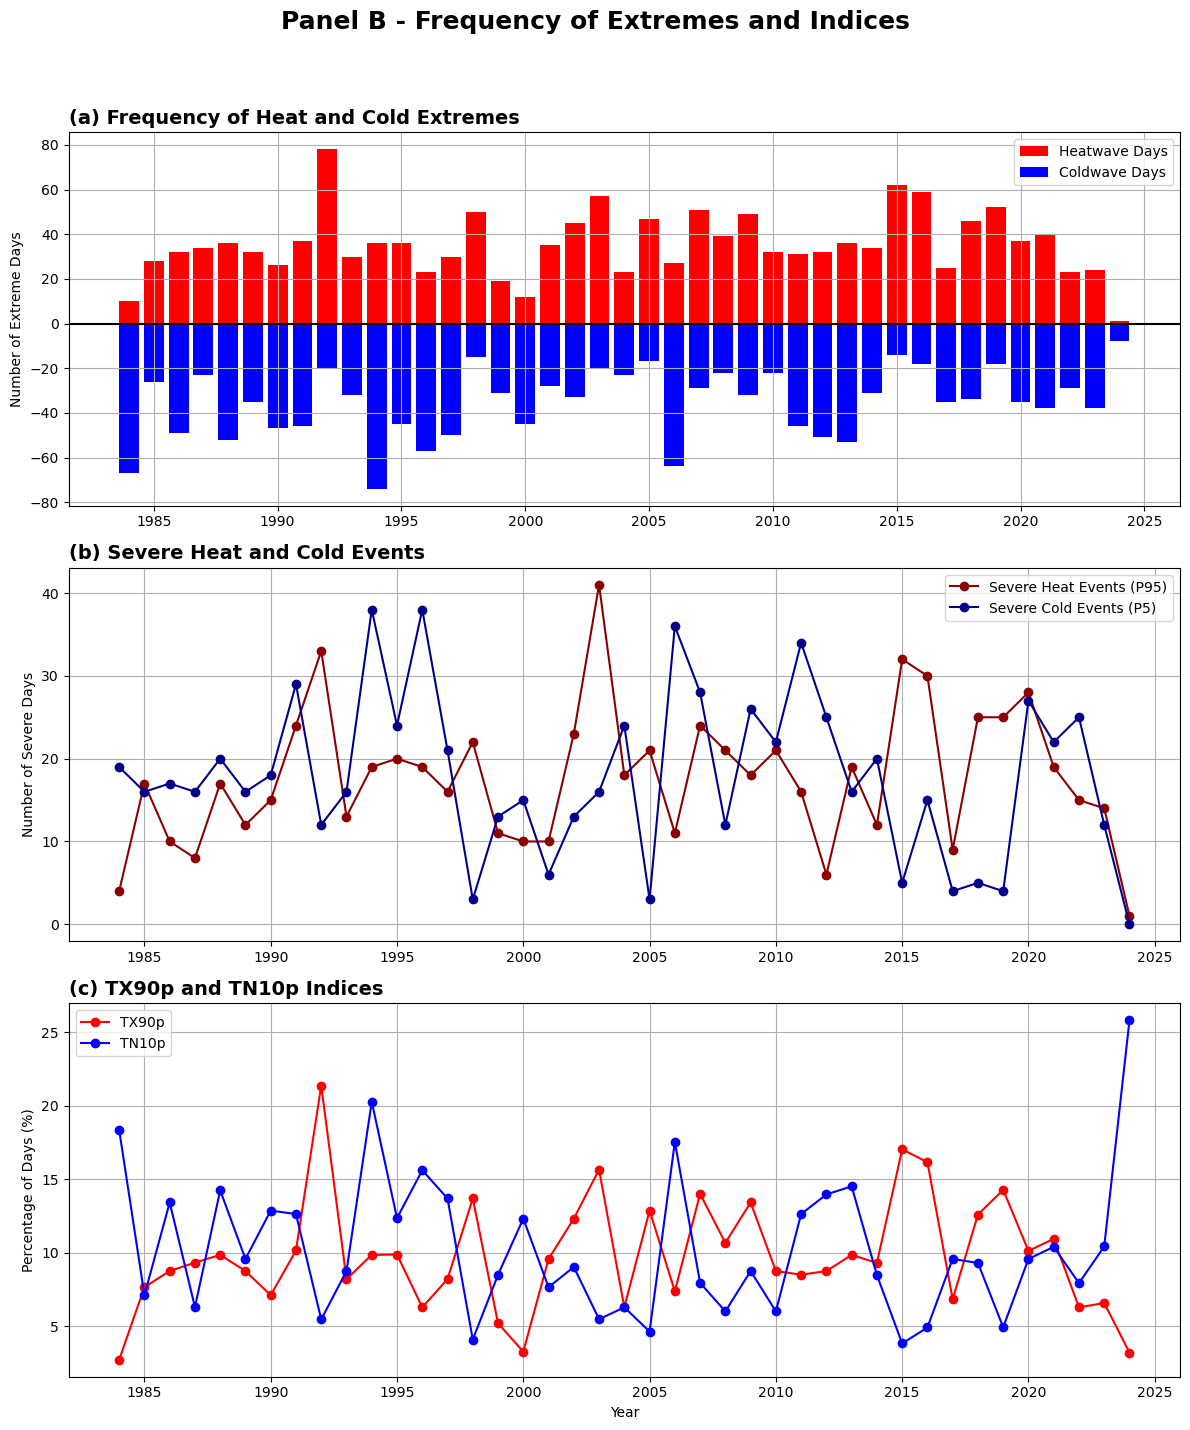

In [77]:
# === Painel B ===
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

# (a) Frequency of heat/cold extremes
axs[0].bar(freq_calor.index, freq_calor.values, color='red', label='Heatwave Days')
axs[0].bar(freq_frio.index, -freq_frio.values, color='blue', label='Coldwave Days')
axs[0].axhline(0, color='black')
axs[0].legend()
axs[0].set_ylabel('Number of Extreme Days')
axs[0].set_title('(a) Frequency of Heat and Cold Extremes', loc='left', fontsize=14, weight='bold')
axs[0].grid(True)

# (b) Frequency of Severe Events
axs[1].plot(freq_severo_calor.index, freq_severo_calor.values, color='darkred', marker='o', label='Severe Heat Events (P95)')
axs[1].plot(freq_severo_frio.index, freq_severo_frio.values, color='darkblue', marker='o', label='Severe Cold Events (P5)')
axs[1].legend()
axs[1].set_ylabel('Number of Severe Days')
axs[1].set_title('(b) Severe Heat and Cold Events', loc='left', fontsize=14, weight='bold')
axs[1].grid(True)

# (c) TX90p and TN10p
axs[2].plot(tx90p.index, tx90p.values, color='red', marker='o', label='TX90p')
axs[2].plot(tn10p.index, tn10p.values, color='blue', marker='o', label='TN10p')
axs[2].legend()
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Percentage of Days (%)')
axs[2].set_title('(c) TX90p and TN10p Indices', loc='left', fontsize=14, weight='bold')
axs[2].grid(True)

fig.suptitle('Panel B - Frequency of Extremes and Indices', fontsize=18, weight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# 📂 Save
fig.savefig('Panel_B_Frequency_Extremes_Indices.png', dpi=300)
plt.show()


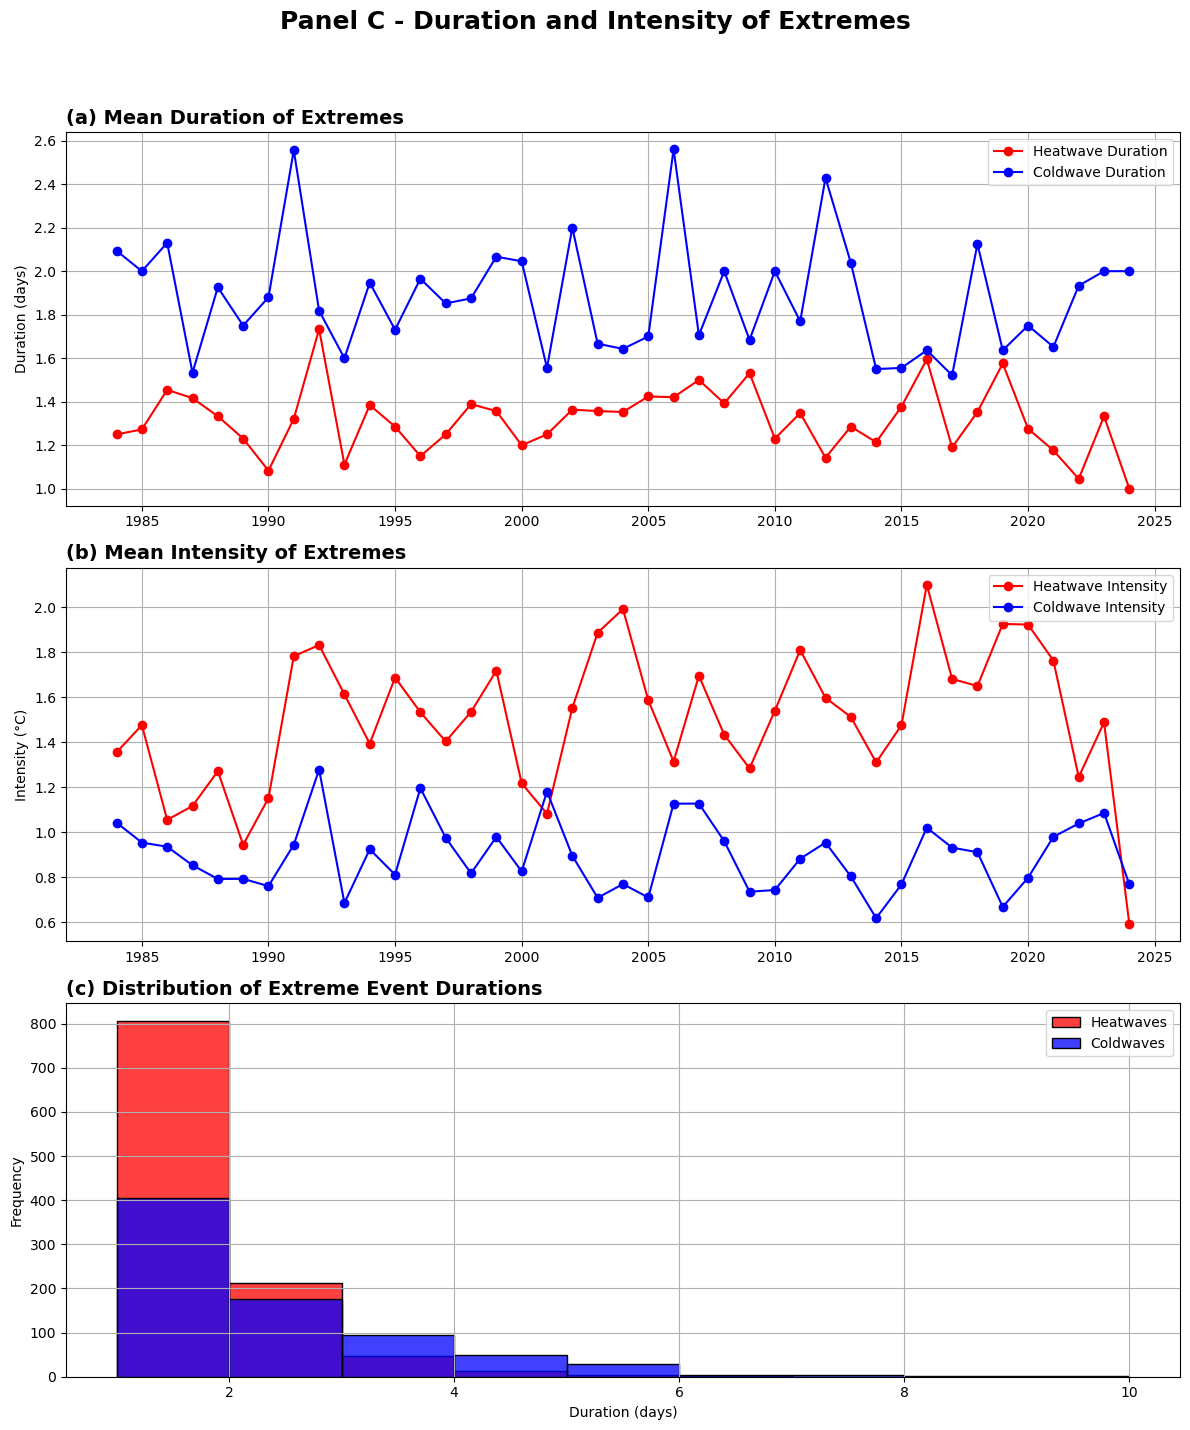

In [78]:
# === Painel C ===
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

# (a) Duration
axs[0].plot(duracao_media_calor.index, duracao_media_calor.values, color='red', marker='o', label='Heatwave Duration')
axs[0].plot(duracao_media_frio.index, duracao_media_frio.values, color='blue', marker='o', label='Coldwave Duration')
axs[0].legend()
axs[0].set_ylabel('Duration (days)')
axs[0].set_title('(a) Mean Duration of Extremes', loc='left', fontsize=14, weight='bold')
axs[0].grid(True)

# (b) Intensity
axs[1].plot(intensidade_calor_ano.index, intensidade_calor_ano.values, color='red', marker='o', label='Heatwave Intensity')
axs[1].plot(intensidade_frio_ano.index, intensidade_frio_ano.values, color='blue', marker='o', label='Coldwave Intensity')
axs[1].legend()
axs[1].set_ylabel('Intensity (°C)')
axs[1].set_title('(b) Mean Intensity of Extremes', loc='left', fontsize=14, weight='bold')
axs[1].grid(True)

# (c) Histogram of durations
sns.histplot(duracoes_calor, bins=range(1, max(duracoes_calor)+2), color='red', ax=axs[2], label='Heatwaves', kde=False)
sns.histplot(duracoes_frio, bins=range(1, max(duracoes_frio)+2), color='blue', ax=axs[2], label='Coldwaves', kde=False)
axs[2].legend()
axs[2].set_xlabel('Duration (days)')
axs[2].set_ylabel('Frequency')
axs[2].set_title('(c) Distribution of Extreme Event Durations', loc='left', fontsize=14, weight='bold')
axs[2].grid(True)

fig.suptitle('Panel C - Duration and Intensity of Extremes', fontsize=18, weight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# 📂 Save
fig.savefig('Panel_C_Duration_Intensity.png', dpi=300)
plt.show()


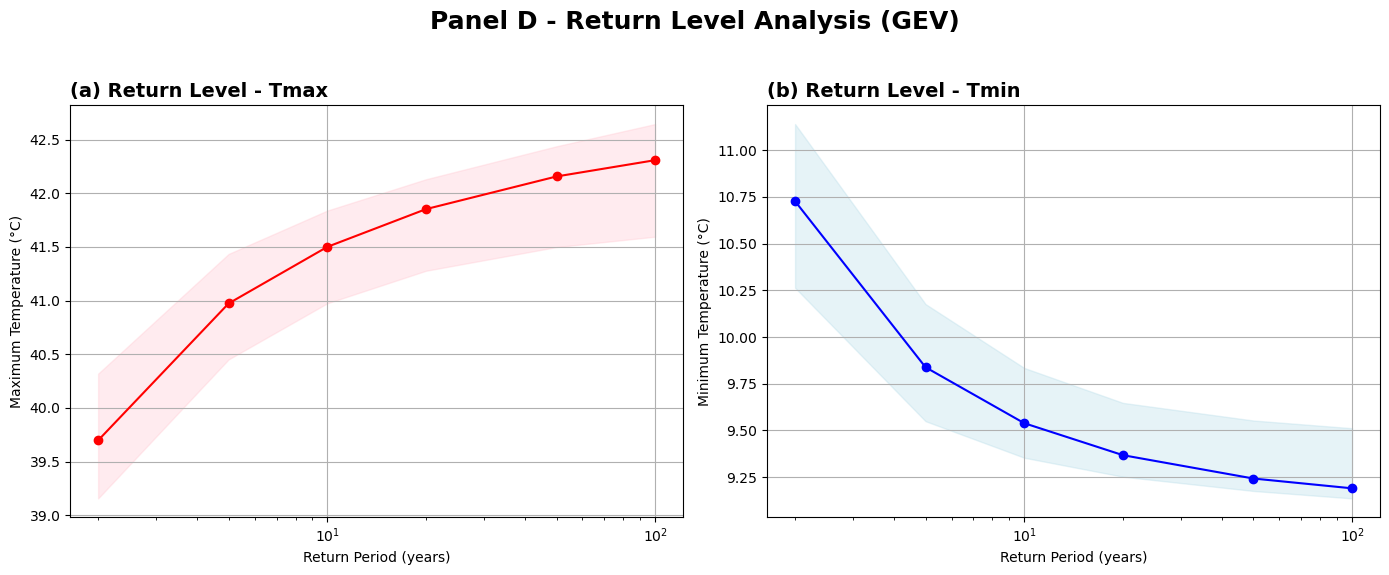

In [ ]:
import cdsapi
c = cdsapi.Client()
